# Neural Network for IMDB Sentiment Classification

This notebook applies the same neural network approach from tensor.ipynb to classify movie reviews as positive or negative sentiment.

In [16]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

## Step 1: Load and Prepare Data

In [17]:
# Load IMDB dataset
df = pd.read_csv('IMDB Dataset.csv')
print(f'Dataset shape: {df.shape}')
print(df.head())

Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [18]:
# Remove duplicates
df = df.drop_duplicates()
print(f'Dataset shape after removing duplicates: {df.shape}')

Dataset shape after removing duplicates: (49582, 2)


In [19]:
# Check sentiment distribution
print(df['sentiment'].value_counts())
print(f'\nSentiment mapping: positive=1, negative=0')

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

Sentiment mapping: positive=1, negative=0


## Step 2: Vectorize Text Data (Convert to Numerical Features)

Similar to how we flattened images in tensor.ipynb, we need to convert text reviews into numerical vectors.

In [20]:
# Convert sentiment labels to binary (positive=1, negative=0)
y = (df['sentiment'] == 'positive').astype(int).values

# Split data into train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['review'].values, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples: {len(X_train_text)}')
print(f'Testing samples: {len(X_test_text)}')

Training samples: 39665
Testing samples: 9917


In [21]:
# Vectorize text using TfidfVectorizer
# This converts text reviews to numerical feature vectors
# Similar to how we flattened 28x28 images to 784 features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_vectorized = vectorizer.fit_transform(X_train_text).toarray()
X_test_vectorized = vectorizer.transform(X_test_text).toarray()

print(f'X_train shape: {X_train_vectorized.shape}')
print(f'X_test shape: {X_test_vectorized.shape}')

X_train shape: (39665, 5000)
X_test shape: (9917, 5000)


In [22]:
# Examine a sample vectorized review
print(f'Sample vectorized review (first 20 features):')
print(X_train_vectorized[0][:20])

Sample vectorized review (first 20 features):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Step 3: Build Neural Network

Build a neural network similar to the one in tensor.ipynb, but adapted for binary classification (positive/negative sentiment).

In [23]:
# Build model with dropout and L2 regularization to reduce overfitting
model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),  # Drop 30% of neurons to prevent overfitting
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),  # Slightly lower dropout on final hidden layer
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

model.summary()

/opt/anaconda3/envs/imdb/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 650,497 (2.48 MB)

 Trainable params: 650,497 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Train the Model

We now use Early Stopping to automatically stop training when validation loss stops improving, preventing overfitting.

In [24]:
# Define early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Stop if no improvement for 2 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model
history = model.fit(
    X_train_vectorized, y_train,
    epochs=15,  # Increased epochs since early stopping will limit training
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Add early stopping
    verbose=1
)

Epoch 1/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8458 - loss: 0.5141 - val_accuracy: 0.8723 - val_loss: 0.4484
Epoch 2/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8458 - loss: 0.5141 - val_accuracy: 0.8723 - val_loss: 0.4484
Epoch 2/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8772 - loss: 0.4456 - val_accuracy: 0.8656 - val_loss: 0.4463
Epoch 3/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8772 - loss: 0.4456 - val_accuracy: 0.8656 - val_loss: 0.4463
Epoch 3/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8835 - loss: 0.4254 - val_accuracy: 0.8750 - val_loss: 0.4380
Epoch 4/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8835 - loss: 0.4254 - val_accuracy: 0.8750 - val_loss: 0.4380
Epoch 4/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8886 - loss: 0.4125 - val_accuracy: 0.8768 - val_loss: 0.4279
Epoch 5/15
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8886 - loss: 0.4125 - val_accuracy: 0.

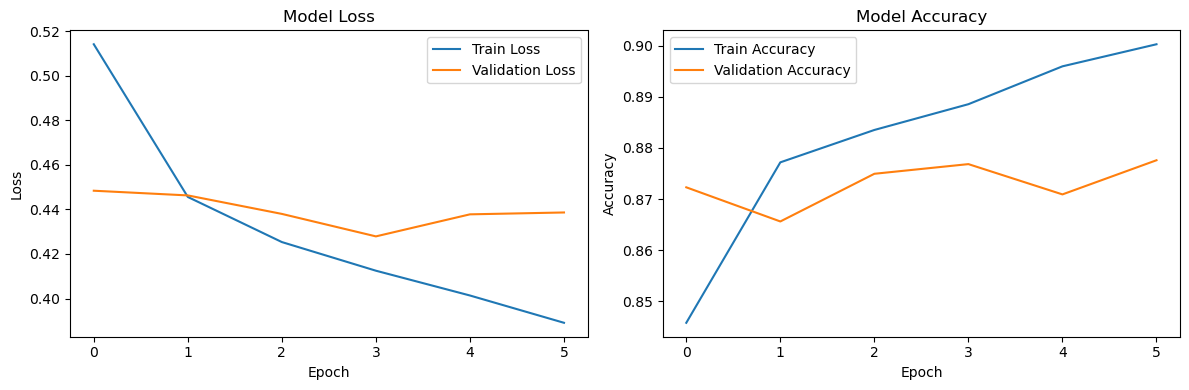

In [25]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Step 5: Evaluate on Test Set

In [26]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_vectorized, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.8813 - loss: 0.4229
Test Accuracy: 0.8813
Test Loss: 0.4229
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.8813 - loss: 0.4229
Test Accuracy: 0.8813
Test Loss: 0.4229


## Step 6: Make Predictions and Build Confusion Matrix

In [27]:
# Get predictions
y_pred_prob = model.predict(X_test_vectorized)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print(f'Sample predictions (first 10):')
print(y_pred[:10])

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
Sample predictions (first 10):
[0 1 1 0 0 1 0 0 1 0]
Sample predictions (first 10):
[0 1 1 0 0 1 0 0 1 0]


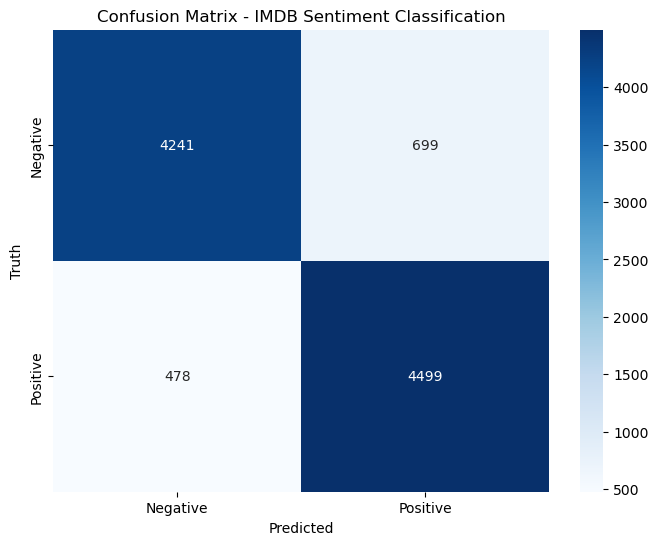

In [28]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - IMDB Sentiment Classification')
plt.show()

In [29]:
# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.86      0.88      4940
    Positive       0.87      0.90      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



## Step 7: Test on Custom Reviews

In [30]:
# Test on custom reviews
custom_reviews = [
    'This movie was absolutely amazing! I loved every minute of it.',
    'Terrible waste of time. Worst movie I have ever seen.',
    'It was okay, not great but not bad either.'
]

# Vectorize custom reviews
custom_vectorized = vectorizer.transform(custom_reviews).toarray()

# Make predictions
custom_predictions = model.predict(custom_vectorized)

# Display results
for review, pred in zip(custom_reviews, custom_predictions):
    sentiment = 'POSITIVE' if pred[0] > 0.5 else 'NEGATIVE'
    confidence = pred[0] if pred[0] > 0.5 else 1 - pred[0]
    print(f'Review: {review}')
    print(f'Prediction: {sentiment} (Confidence: {confidence:.2%})\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Review: This movie was absolutely amazing! I loved every minute of it.
Prediction: POSITIVE (Confidence: 98.84%)

Review: Terrible waste of time. Worst movie I have ever seen.
Prediction: NEGATIVE (Confidence: 99.99%)

Review: It was okay, not great but not bad either.
Prediction: NEGATIVE (Confidence: 94.27%)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Review: This movie was absolutely amazing! I loved every minute of it.
Prediction: POSITIVE (Confidence: 98.84%)

Review: Terrible waste of time. Worst movie I have ever seen.
Prediction: NEGATIVE (Confidence: 99.99%)

Review: It was okay, not great but not bad either.
Prediction: NEGATIVE (Confidence: 94.27%)

